In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels as sm

from statsmodels.tsa.stattools import adfuller,kpss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pylab import rcParams

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM # Long Short Term Memory

import pickle

In [2]:
data = pd.read_csv(r"C:\Users\aksha\Desktop\Internship\Ai Varient\Demand Forecasting\train (2).csv")

# EDA

In [3]:
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['days'] = data['date'].dt.day_name()

In [7]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,month,year,days
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,1,2013,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,1,2013,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,1,2013,Tuesday


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   month        int64         
 7   year         int64         
 8   days         object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 206.1+ MB


In [9]:
data.describe()

,id,store_nbr,sales,onpromotion,month,year
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00,6.207838e+00,2.014838e+03
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01,3.385668e+00,1.345518e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00,3.000000e+00,2.014000e+03
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00,6.000000e+00,2.015000e+03
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00,9.000000e+00,2.016000e+03
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.200000e+01,2.017000e+03


In [10]:
data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
month          0
year           0
days           0
dtype: int64

In [11]:
data.duplicated().sum()

0

In [12]:
data.corr()

,id,store_nbr,sales,onpromotion,month,year
id,1.000000,3.013308e-04,0.085784,0.206260,6.743357e-02,9.776028e-01
store_nbr,0.000301,1.000000e+00,0.041196,0.007286,-4.946280e-15,8.754910e-15
sales,0.085784,4.119605e-02,1.000000,0.427923,1.978967e-02,8.109275e-02
onpromotion,0.206260,7.285647e-03,0.427923,1.000000,2.588107e-02,1.990601e-01
month,0.067434,-4.946280e-15,0.019790,0.025881,1.000000e+00,-1.432929e-01
year,0.977603,8.754910e-15,0.081093,0.199060,-1.432929e-01,1.000000e+00


# Visualization

<AxesSubplot:>

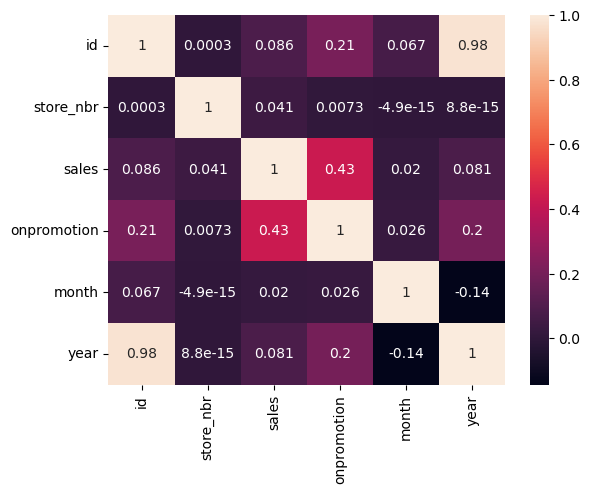

In [13]:
sns.heatmap(data.corr(), annot = True)

In [14]:
store_sales = data.groupby('store_nbr')['sales'].sum()

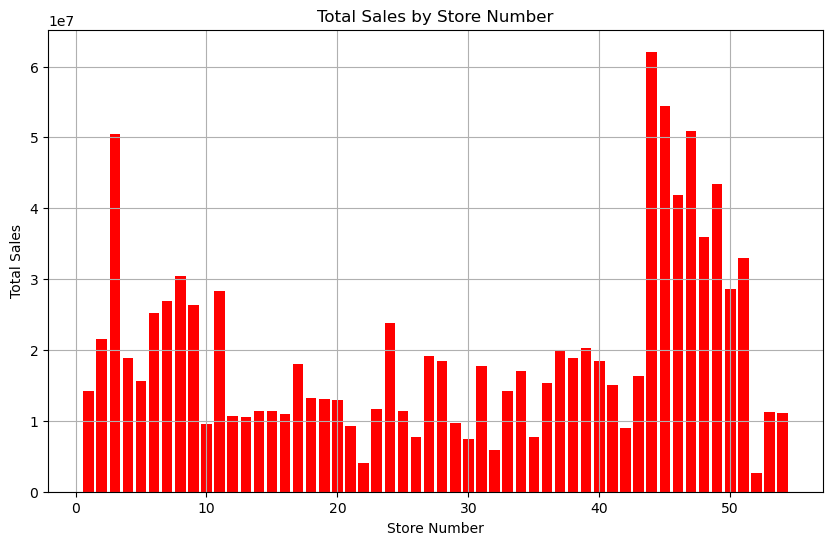

In [15]:
plt.figure(figsize=(10,6))
plt.bar(store_sales.index, store_sales.values, color ='red')

plt.title('Total Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [16]:
family_sales = data.groupby('family')['sales'].sum()
family_sales = family_sales.sort_values(ascending=False)

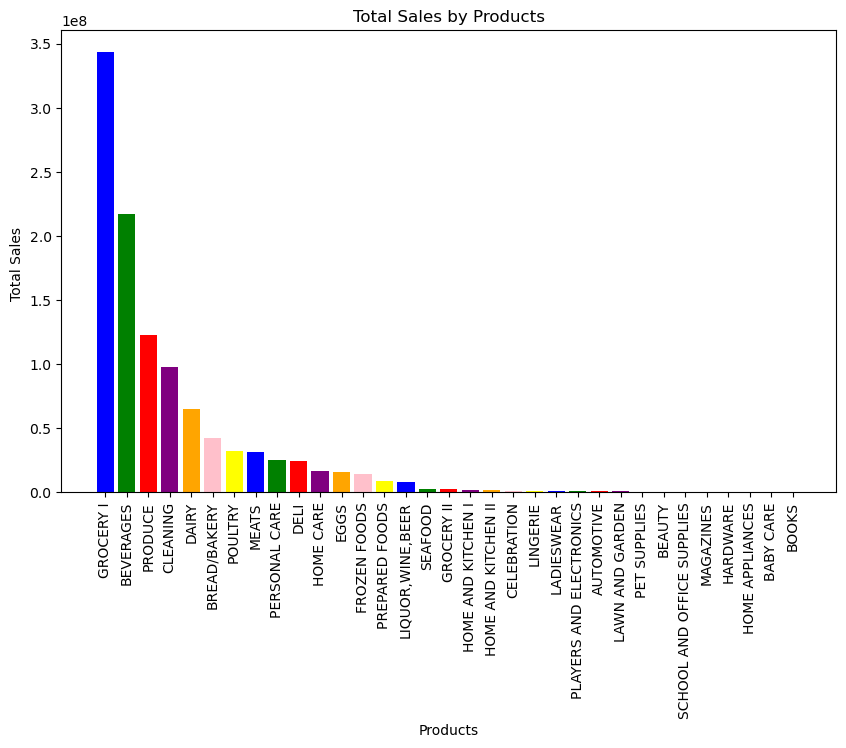

In [17]:
plt.figure(figsize=(10,6))
colors = ['blue', 'green', 'red', 'purple', 'orange','pink','yellow']
plt.bar(family_sales.index, family_sales.values, color =colors)

plt.title('Total Sales by Products')
plt.xlabel('Products')
plt.ylabel('Total Sales ')
plt.xticks(rotation=90)
plt.show()

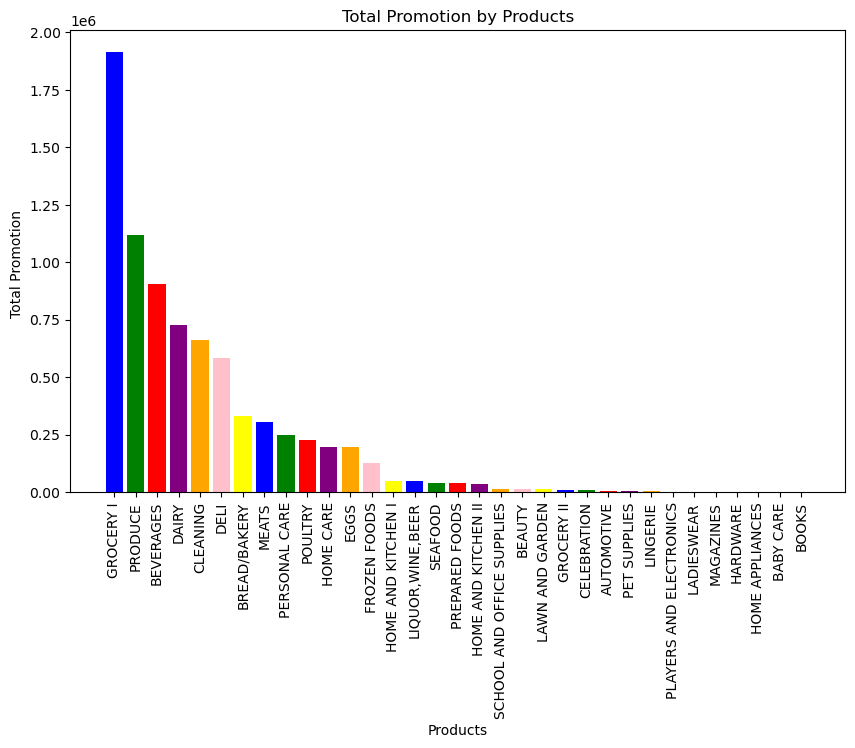

In [18]:
family_sales = data.groupby('family')['onpromotion'].sum()
family_sales = family_sales.sort_values(ascending=False)

plt.figure(figsize=(10,6))
colors = ['blue', 'green', 'red', 'purple', 'orange','pink','yellow']
plt.bar(family_sales.index, family_sales.values, color =colors)

plt.title('Total Promotion by Products')
plt.xlabel('Products')
plt.ylabel('Total Promotion ')
plt.xticks(rotation=90)
plt.show()

In [19]:
store_promote = data.groupby('store_nbr')['onpromotion'].sum()

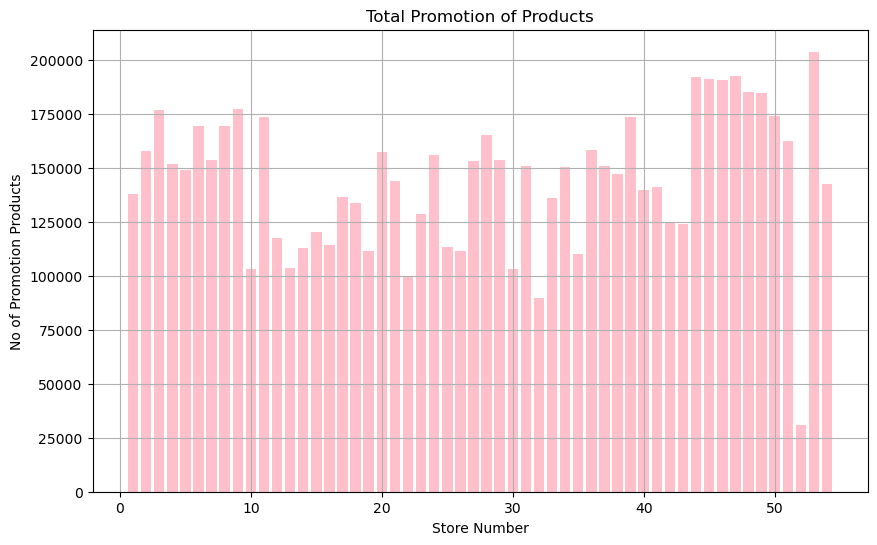

In [20]:
plt.figure(figsize=(10,6))
plt.bar(store_promote.index, store_promote.values, color='pink')

plt.title('Total Promotion of Products')
plt.xlabel('Store Number')
plt.ylabel('No of Promotion Products')
plt.grid(True)
plt.show()

In [21]:
weekdays_sales = data.groupby(data['days'])['sales'].sum()
weekdays_sales = weekdays_sales.sort_values(ascending=False)

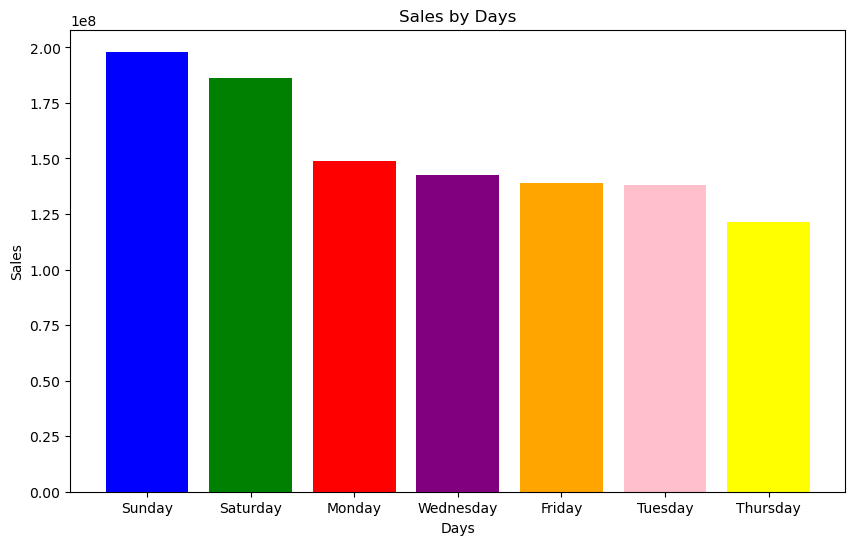

In [22]:
plt.figure(figsize=(10,6))
plt.bar(weekdays_sales.index, weekdays_sales.values, color=colors)

plt.title('Sales by Days')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.show()

In [23]:
month_sales = data.groupby(data['month'])['sales'].sum()
month_sales = month_sales.sort_values(ascending=False)

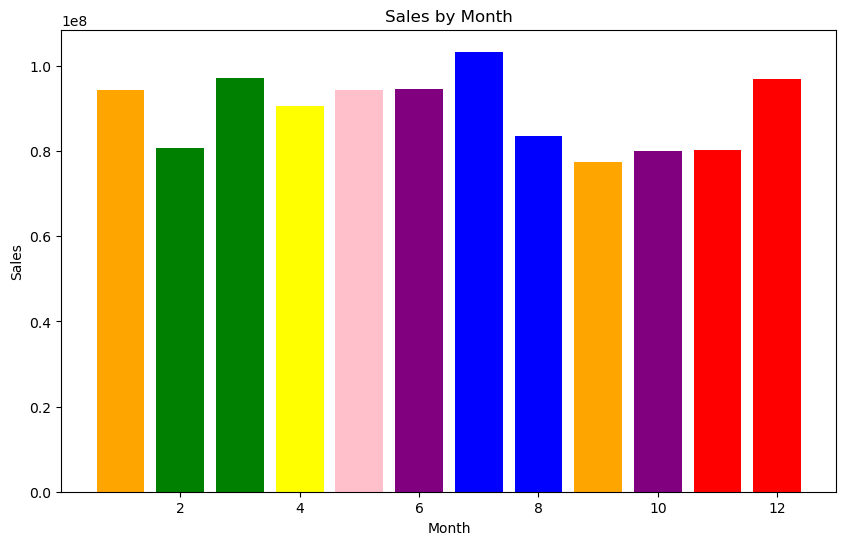

In [24]:
plt.figure(figsize=(10,6))
plt.bar(month_sales.index, month_sales.values, color=colors)

plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

In [25]:
year_sales = data.groupby(data['year'])['sales'].sum()
year_sales = year_sales.sort_values(ascending=False)

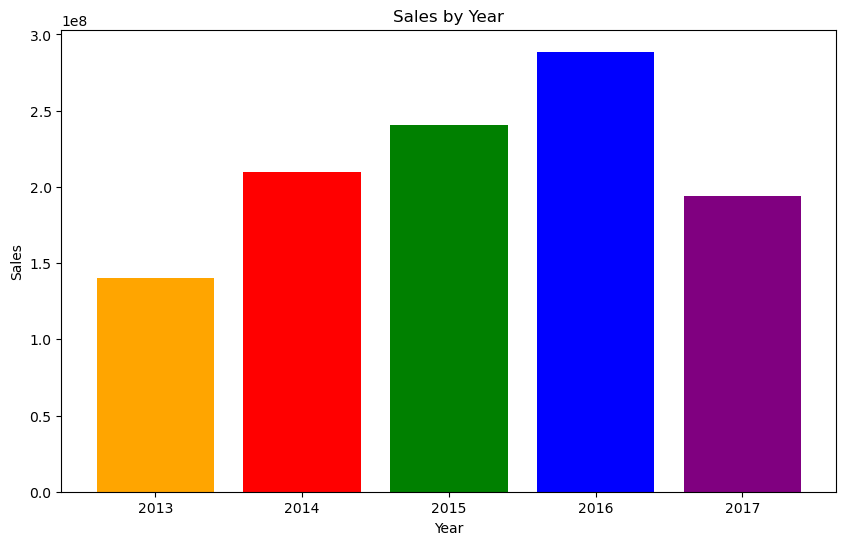

In [26]:
plt.figure(figsize=(10,6))
plt.bar(year_sales.index, year_sales.values, color=colors)

plt.title('Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

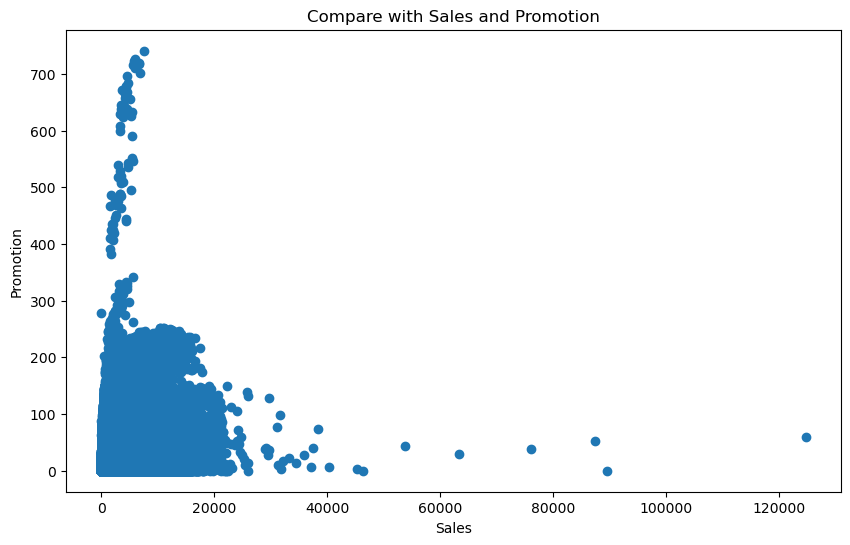

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(x='sales', y='onpromotion', data=data)

plt.title('Compare with Sales and Promotion')
plt.xlabel('Sales')
plt.ylabel('Promotion')
plt.show()

Text(0.5, 1.0, 'Sales')

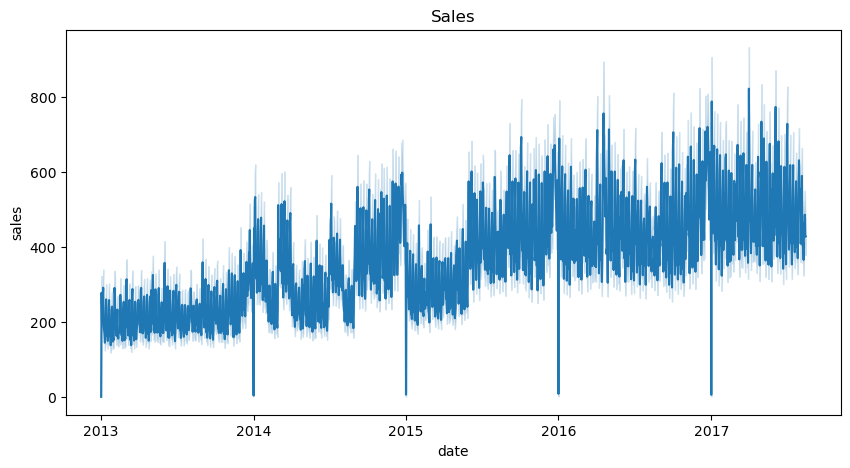

In [28]:
plt.figure(figsize=(10,5))
sns.lineplot(x='date',y='sales',data=data)
plt.title('Sales')

In [29]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,month,year,days
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,1,2013,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,1,2013,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,1,2013,Tuesday


In [30]:
ts_data = data.drop(data.iloc[:,[0,2,3,5,6,7,8,]], axis=1)
ts_data.set_index('date')

,sales
date,
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
2013-01-01,0.000
...,...
2017-08-15,438.133
2017-08-15,154.553
2017-08-15,2419.729


In [31]:
def kpss_test(timeseries):
    print('result of KPSS test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'P_value', 'Lags Used'])
    
    critical_values = pd.Series(kpsstest[3], name='Critical Values')
    
    kpss_output = kpss_output.append(critical_values)
    
    print(kpss_output)

kpss_test(ts_data.sales)

result of KPSS test:
Test Statistic    147.407103
P_value             0.010000
Lags Used         695.000000
10%                 0.347000
5%                  0.463000
2.5%                0.574000
1%                  0.739000
dtype: float64


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\aksha\AppData\Local\Temp\ipykernel_10280\509210829.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kpss_output = kpss_output.append(critical_values)


<AxesSubplot:>

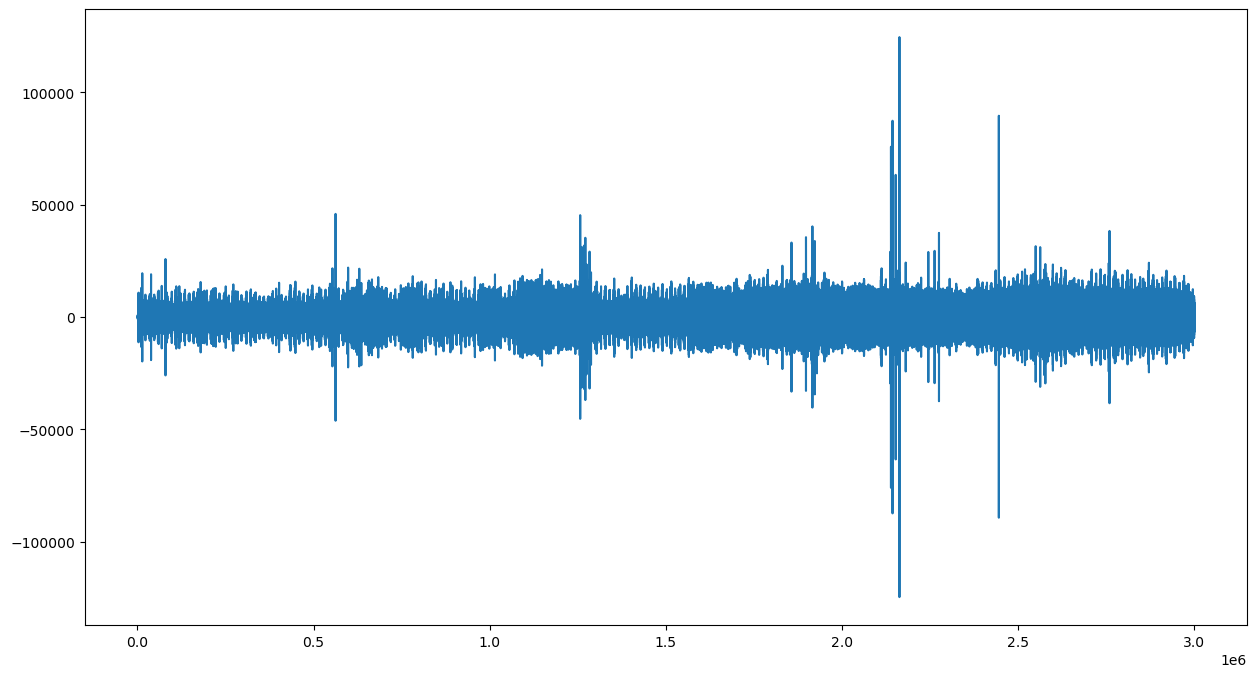

In [32]:
#Differencing
plt.figure(figsize=(15,8))
ts_data['sales_diff'] = ts_data['sales'] - ts_data['sales'].shift(1)
ts_data['sales_diff'].dropna().plot()

Text(0.5, 1.0, 'Sales')

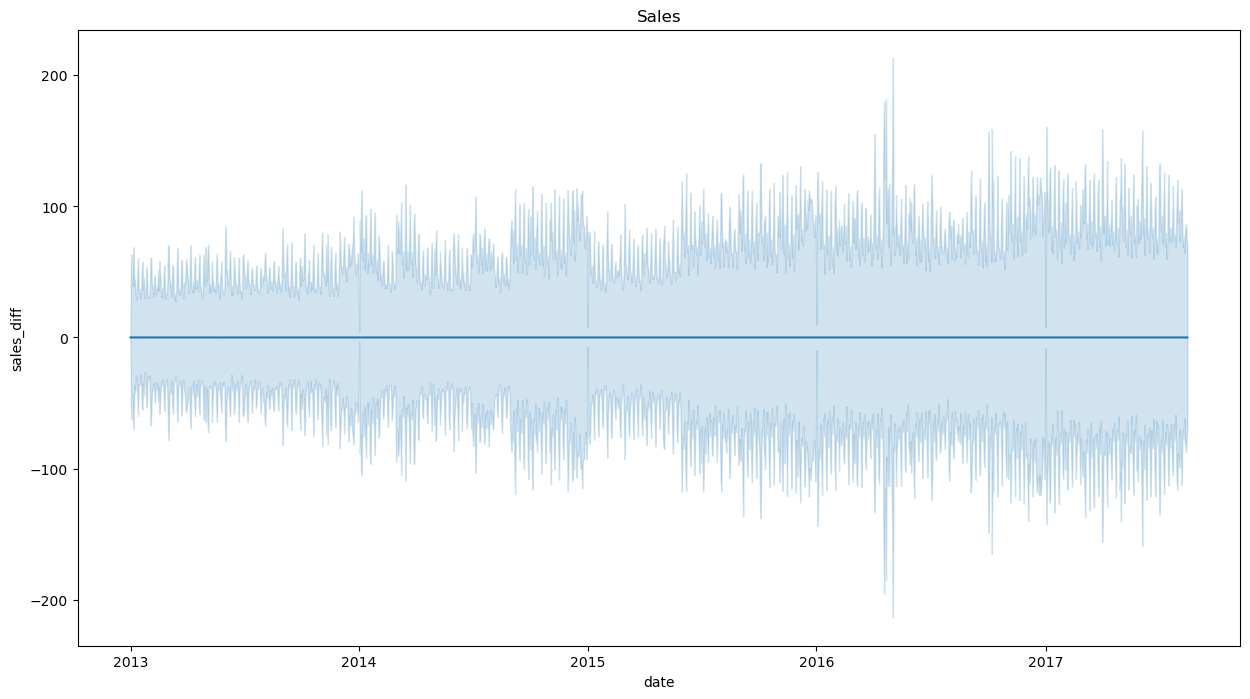

In [33]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date',y='sales_diff',data=ts_data)
plt.title('Sales')

In [34]:
def kpss_test(timeseries):
    print('result of KPSS test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'P_value', 'Lags Used'])
    
    critical_values = pd.Series(kpsstest[3], name='Critical Values')
    
    kpss_output = kpss_output.append(critical_values)
    
    print(kpss_output)

kpss_test(ts_data.sales_diff.iloc[1:])

result of KPSS test:
Test Statistic      0.000129
P_value             0.100000
Lags Used         735.000000
10%                 0.347000
5%                  0.463000
2.5%                0.574000
1%                  0.739000
dtype: float64


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\aksha\AppData\Local\Temp\ipykernel_10280\651880741.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kpss_output = kpss_output.append(critical_values)


In [35]:
ts_data

,date,sales,sales_diff
0,2013-01-01,0.000,NaN
1,2013-01-01,0.000,0.000
2,2013-01-01,0.000,0.000
3,2013-01-01,0.000,0.000
4,2013-01-01,0.000,0.000
...,...,...,...
3000883,2017-08-15,438.133,432.133
3000884,2017-08-15,154.553,-283.580
3000885,2017-08-15,2419.729,2265.176
3000886,2017-08-15,121.000,-2298.729


In [36]:
df = ts_data.resample('W',on='date')['sales','sales_diff'].sum()/100
df = df.drop('sales_diff', axis=1)
df = df.iloc[:241]

In [37]:
df

,sales
date,
2013-01-06,22115.704675
2013-01-13,23736.178362
2013-01-20,23680.074300
2013-01-27,22721.646701
2013-02-03,24768.906712
...,...
2017-07-16,57485.154291
2017-07-23,57443.351642
2017-07-30,59218.118568


In [38]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    critical_values = pd.Series(dftest[3], name='Critical Values')
    
    dfoutput = dfoutput.append(critical_values)
    
    print (dfoutput)

adf_test(df.sales)

Results of Dickey-Fuller Test:
Test Statistic                  -1.416404
p-value                          0.574387
#Lags Used                      13.000000
Number of Observations Used    227.000000
0                              227.000000
dtype: float64


C:\Users\aksha\AppData\Local\Temp\ipykernel_10280\48950711.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfoutput = dfoutput.append(critical_values)


<AxesSubplot:xlabel='date'>

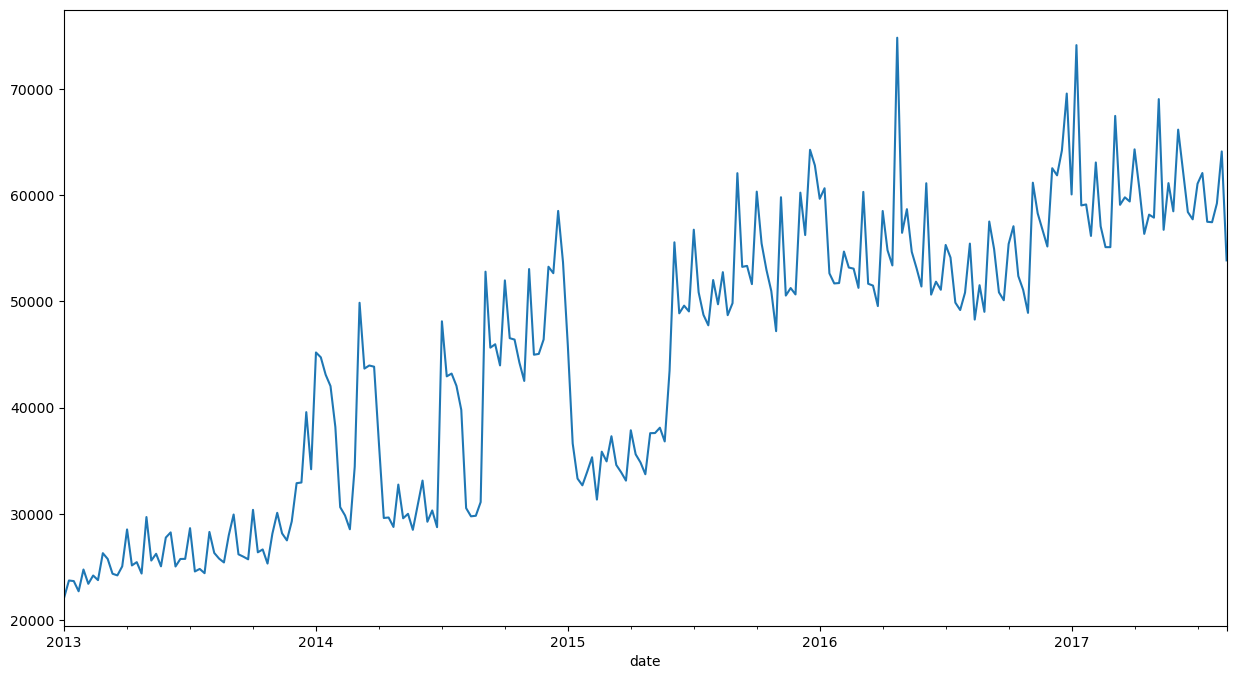

In [39]:
plt.figure(figsize=(15,8))
df['sales'].plot()

In [40]:
train, test= train_test_split(df, train_size=0.8, shuffle=False)

In [41]:
train.shape, test.shape

((192, 1), (49, 1))

In [42]:
train

,sales
date,
2013-01-06,22115.704675
2013-01-13,23736.178362
2013-01-20,23680.074300
2013-01-27,22721.646701
2013-02-03,24768.906712
...,...
2016-08-07,55432.185400
2016-08-14,48283.157891
2016-08-21,51516.237768


In [43]:
test

,sales
date,
2016-09-11,54920.163460
2016-09-18,50845.858474
2016-09-25,50102.133216
2016-10-02,55393.441842
2016-10-09,57067.307212
2016-10-16,52376.432961
2016-10-23,51079.534130
2016-10-30,48916.250538
2016-11-06,61161.878713


Text(0.5, 1.0, 'Train Data')

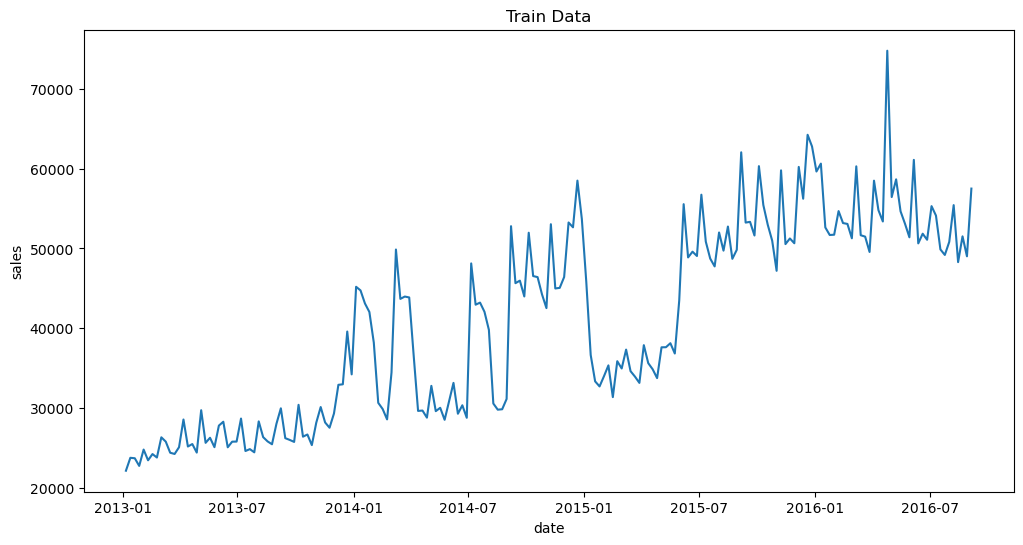

In [44]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='sales',data=train)
plt.title('Train Data')

Text(0.5, 1.0, 'Test Data')

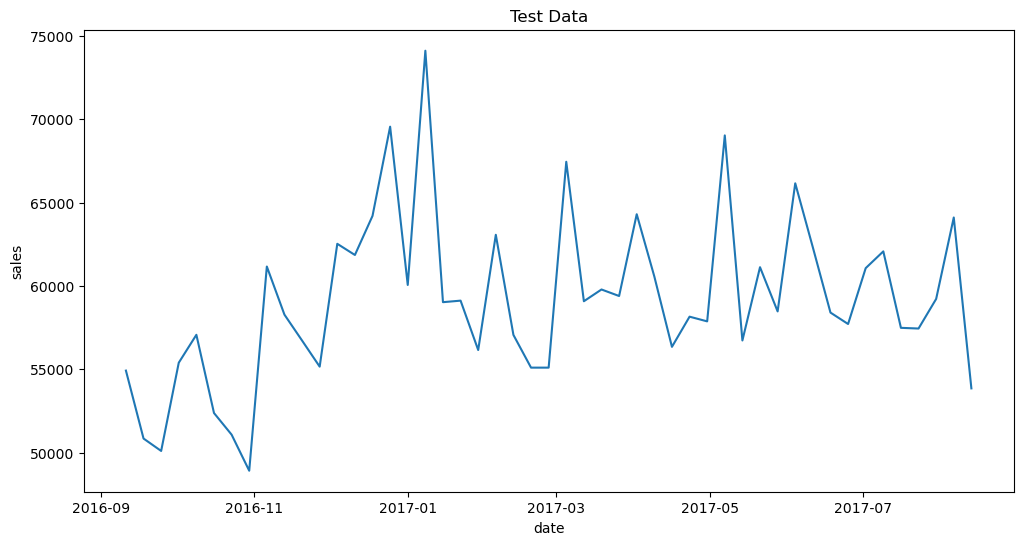

In [45]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='sales',data=test)
plt.title('Test Data')

<AxesSubplot:xlabel='date'>

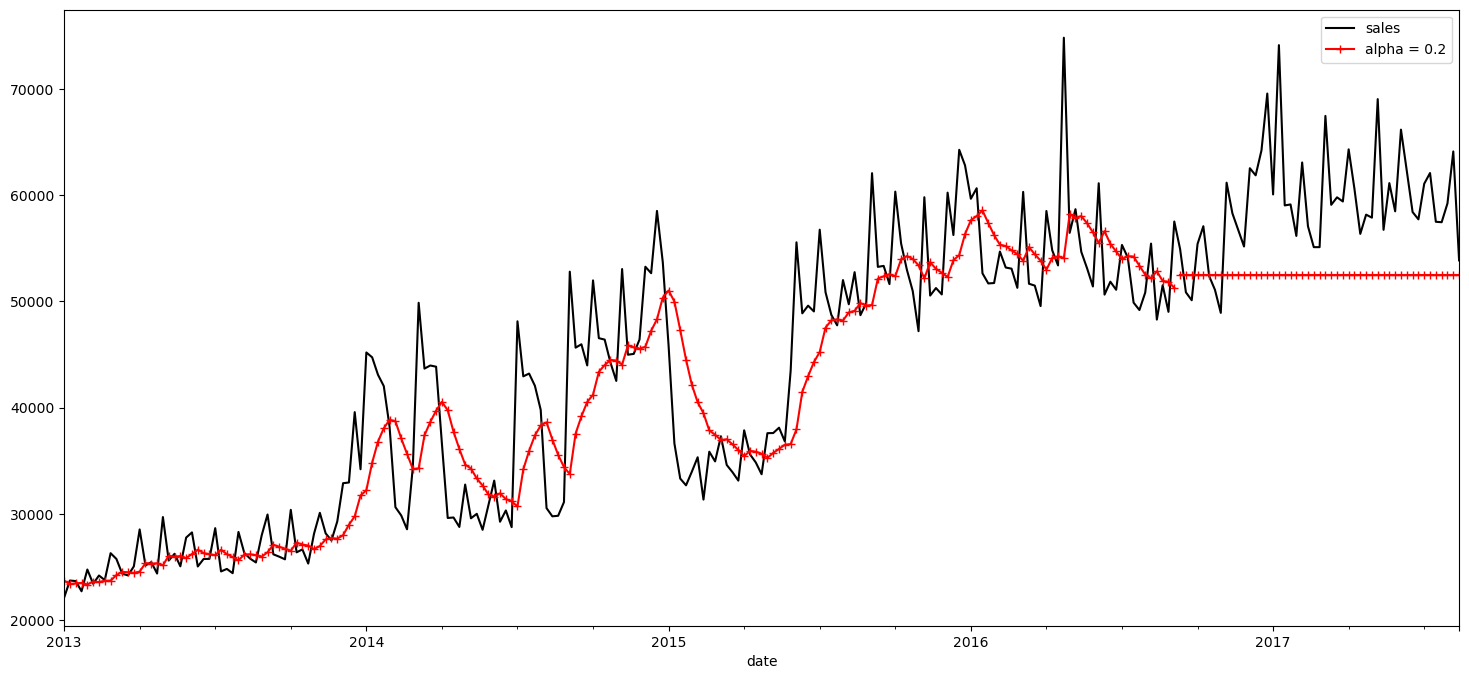

In [46]:
model1 = SimpleExpSmoothing(train).fit(smoothing_level=0.2)
pred1 = model1.forecast(49).rename('alpha = 0.2')

ax = df.plot( color='black', figsize=(18,8), legend=True)

pred1.plot(marker='+', ax=ax, color='red', legend=True)
model1.fittedvalues.plot(marker='+', ax=ax, color='red')

In [47]:
rmse_of_SES_SL_2 = np.sqrt(mean_squared_error(y_true= test, y_pred= pred1))
mape_of_SES_SL_2 = mean_absolute_percentage_error(y_true= test, y_pred= pred1)
print('Rmse of Simple Exponential Smoothing of 0.2:',rmse_of_SES_SL_2)
print('Mape of Simple Exponential Smoothing of 0.2:',mape_of_SES_SL_2)

Rmse of Simple Exponential Smoothing of 0.2: 8270.714274485437
Mape of Simple Exponential Smoothing of 0.2: 0.11308169397541279


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

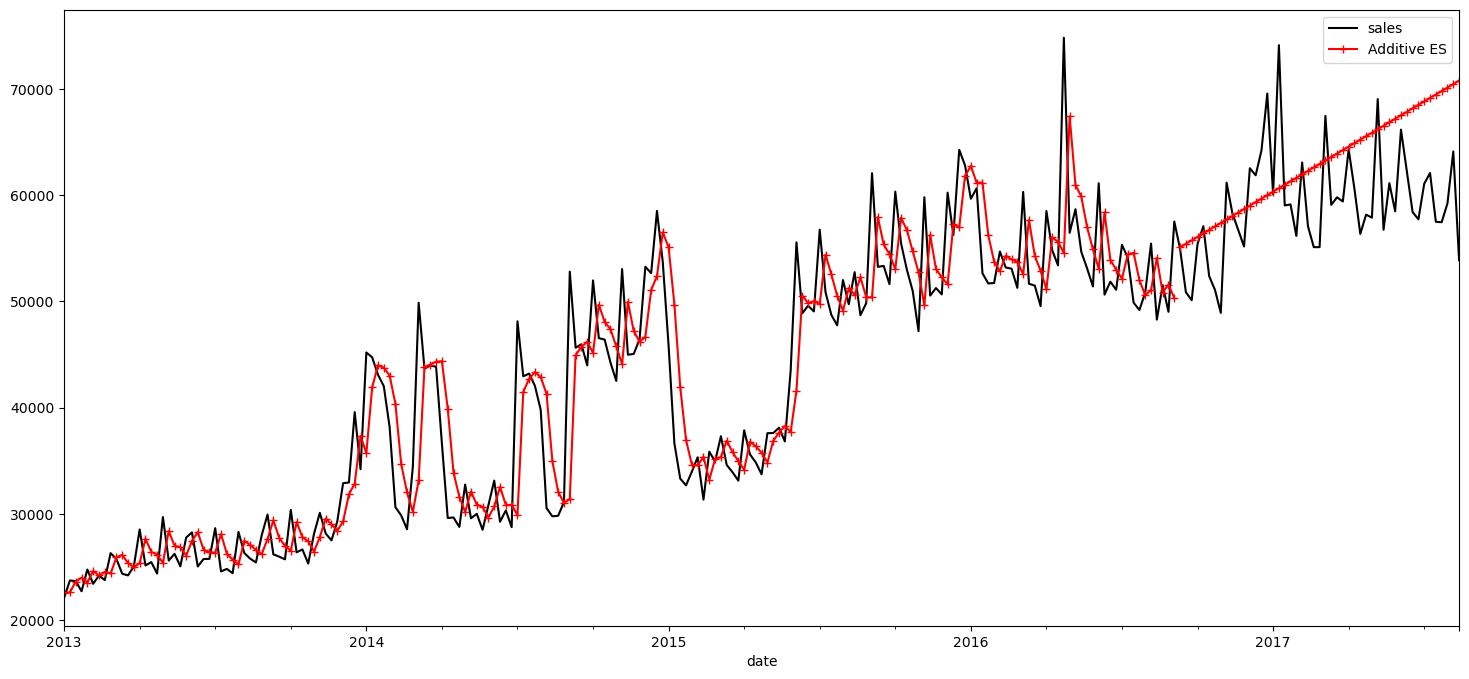

In [48]:
add_model = ExponentialSmoothing(train, trend='add').fit()
add_pred = add_model.forecast(49).rename('Additive ES')

ax = df.plot( color='black', figsize=(18,8), legend=True)

add_pred.plot(marker='+', ax=ax, color='red', legend=True)
add_model.fittedvalues.plot(marker='+', ax=ax, color='red')

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

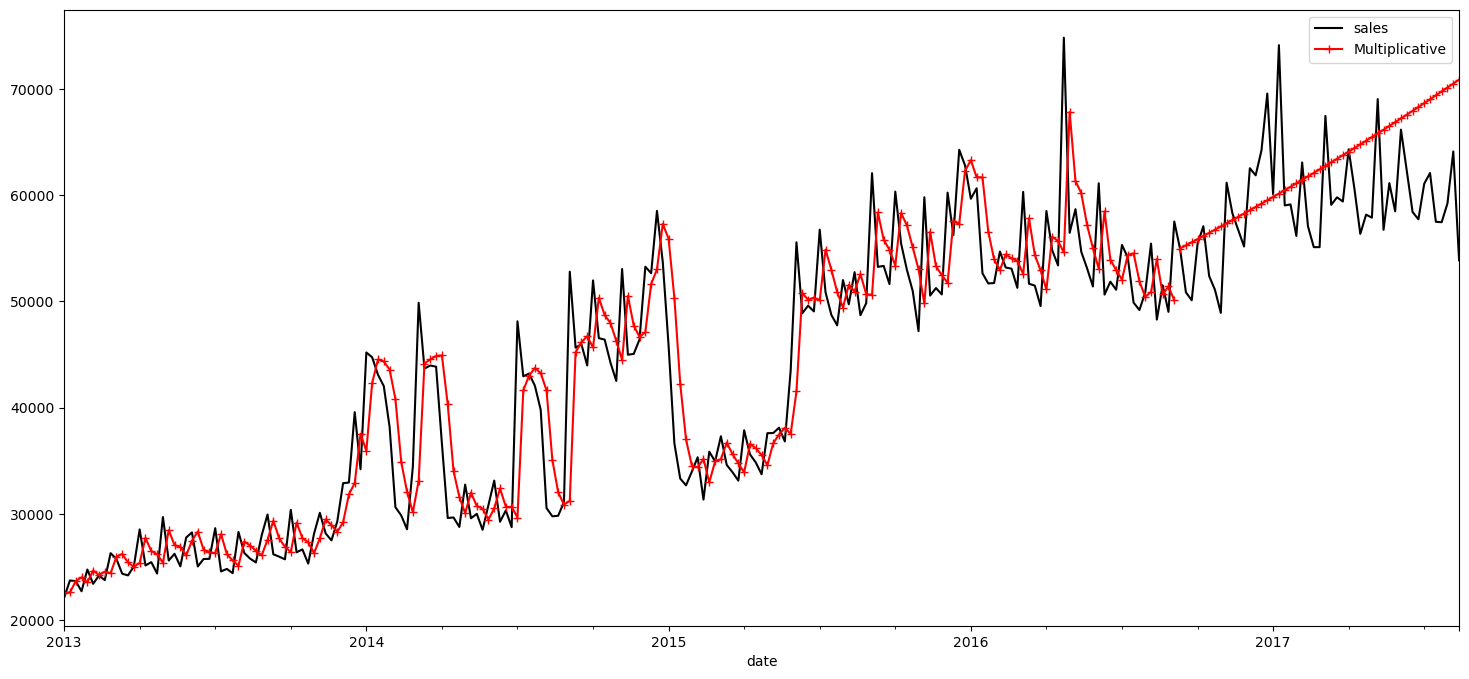

In [49]:
mul_model = ExponentialSmoothing(train, trend='mul').fit()
mul_pred = mul_model.forecast(49).rename('Multiplicative')

ax = df.plot( color='black', figsize=(18,8), legend=True)

mul_pred.plot(marker='+', ax=ax, color='red', legend=True)
mul_model.fittedvalues.plot(marker='+', ax=ax, color='red')

In [50]:
rmse_of_AES = np.sqrt(mean_squared_error(y_true= test, y_pred= add_pred))
mape_of_AES = mean_absolute_percentage_error(y_true= test, y_pred= add_pred)
print('Rmse of Additive Exponential Smoothing :',rmse_of_AES)
print('Mape of Additive Exponential Smoothing :',mape_of_AES)

rmse_of_MES = np.sqrt(mean_squared_error(y_true= test, y_pred= mul_pred))
mape_of_MES = mean_absolute_percentage_error(y_true= test, y_pred= mul_pred)
print('Rmse of multiplicative Exponential Smoothing :',rmse_of_MES)
print('Mape of multiplicative Exponential Smoothing :',mape_of_MES)

Rmse of Additive Exponential Smoothing : 6855.468888499445
Mape of Additive Exponential Smoothing : 0.09727578089390729
Rmse of multiplicative Exponential Smoothing : 6746.496967765898
Mape of multiplicative Exponential Smoothing : 0.09480426293394834


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

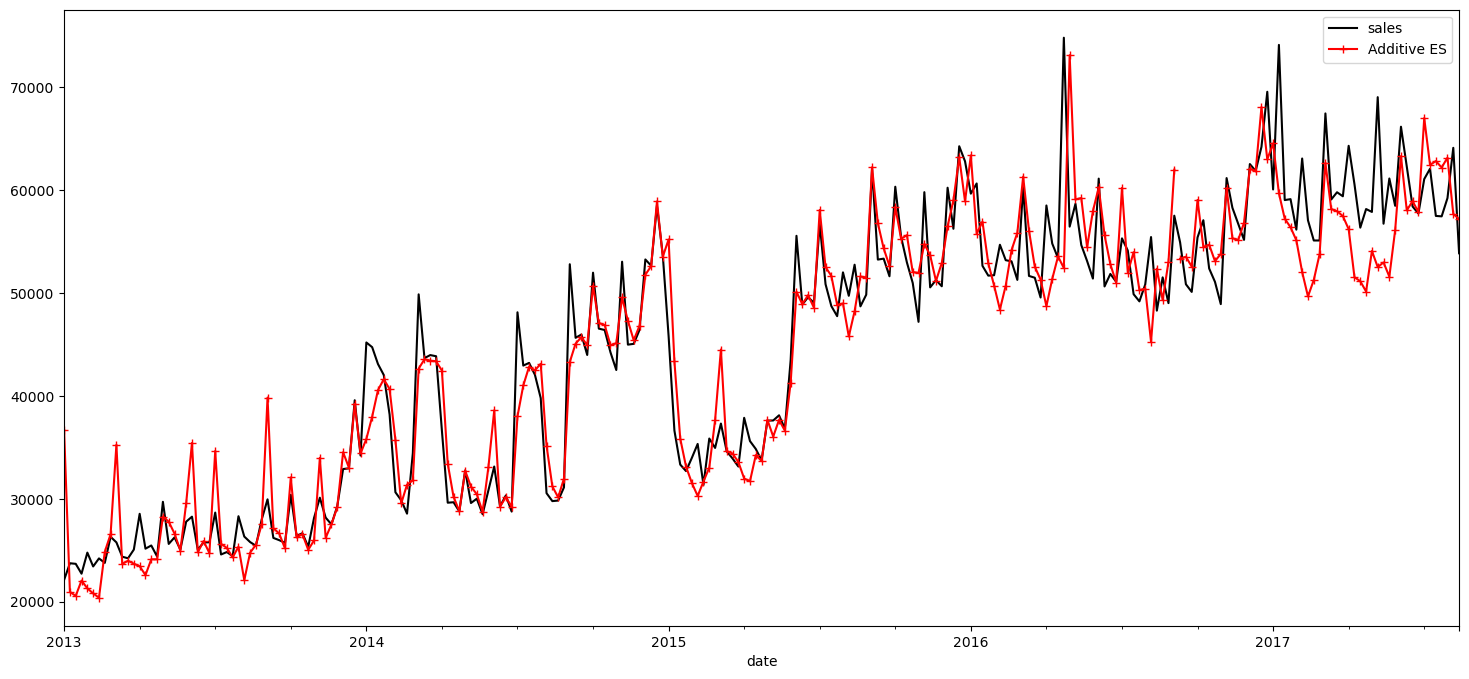

In [51]:
additive_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit()
additive_pred = additive_model.forecast(49).rename('Additive ES')

ax = df.plot( color='black', figsize=(18,8), legend=True)

additive_pred.plot(marker='+', ax=ax, color='red', legend=True)
additive_model.fittedvalues.plot(marker='+', ax=ax, color='red')

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

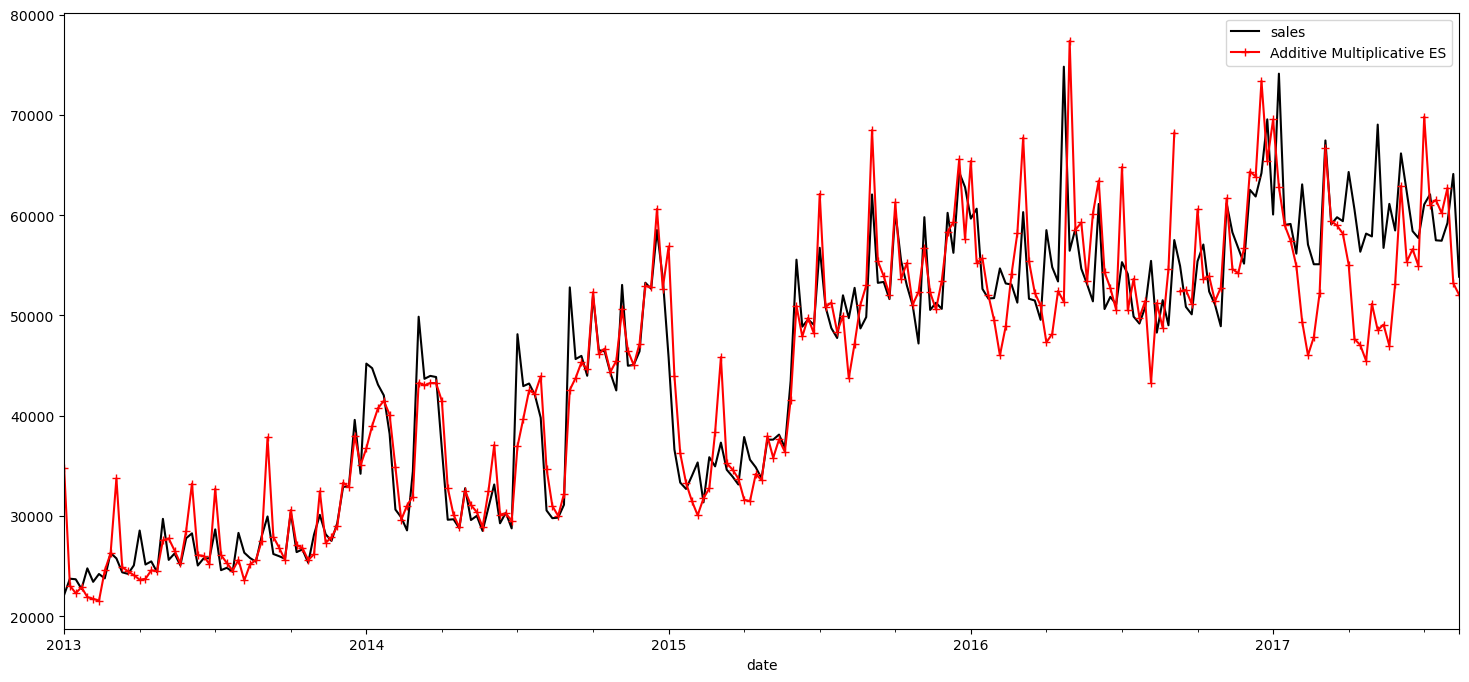

In [52]:
addmulticative_model = ExponentialSmoothing(train, trend='add', seasonal='mul').fit()
addmulticative_pred = addmulticative_model.forecast(49).rename('Additive Multiplicative ES')

ax = df.plot( color='black', figsize=(18,8), legend=True)

addmulticative_pred.plot(marker='+', ax=ax, color='red', legend=True)
addmulticative_model.fittedvalues.plot(marker='+', ax=ax, color='red')

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

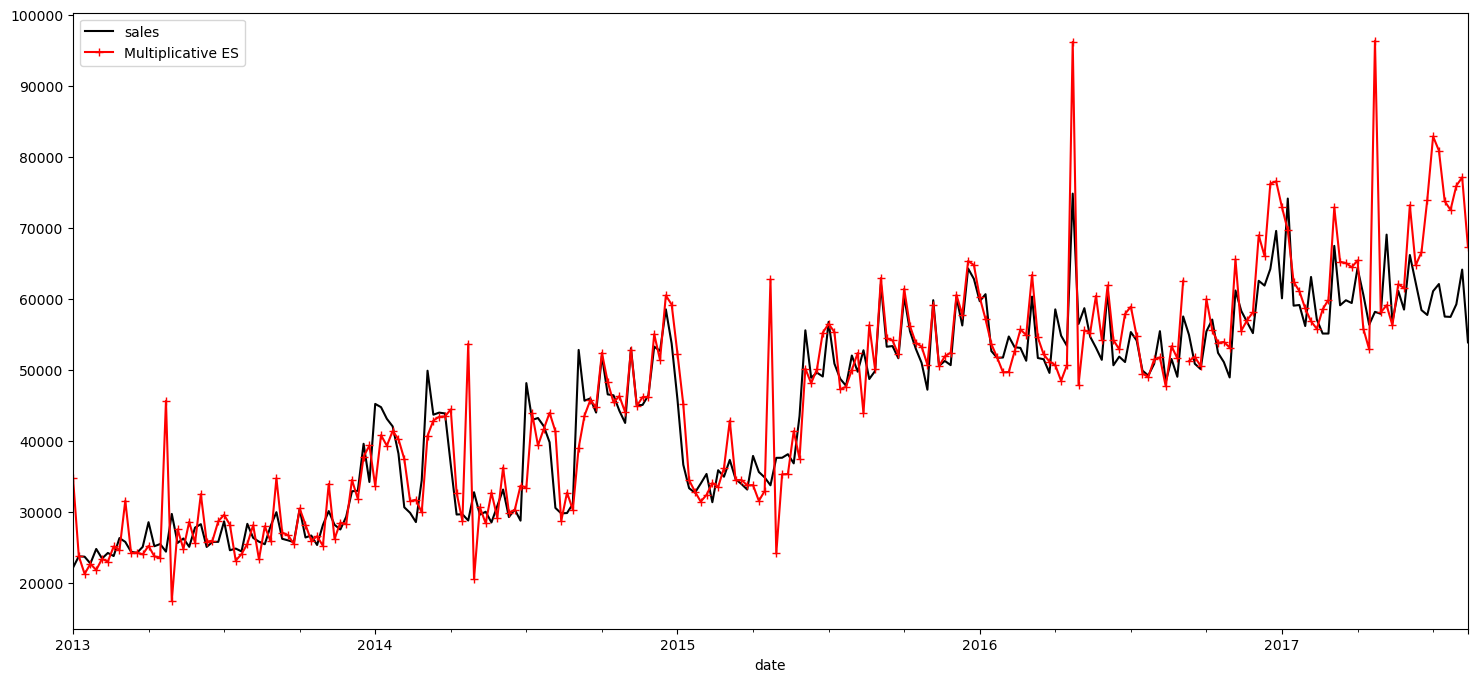

In [53]:
multiplicative_model = ExponentialSmoothing(train, trend='mul', seasonal='mul').fit()
multiplicative_pred = multiplicative_model.forecast(49).rename('Multiplicative ES')

ax = df.plot( color='black', figsize=(18,8), legend=True)

multiplicative_pred.plot(marker='+', ax=ax, color='red', legend=True)
multiplicative_model.fittedvalues.plot(marker='+', ax=ax, color='red')

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

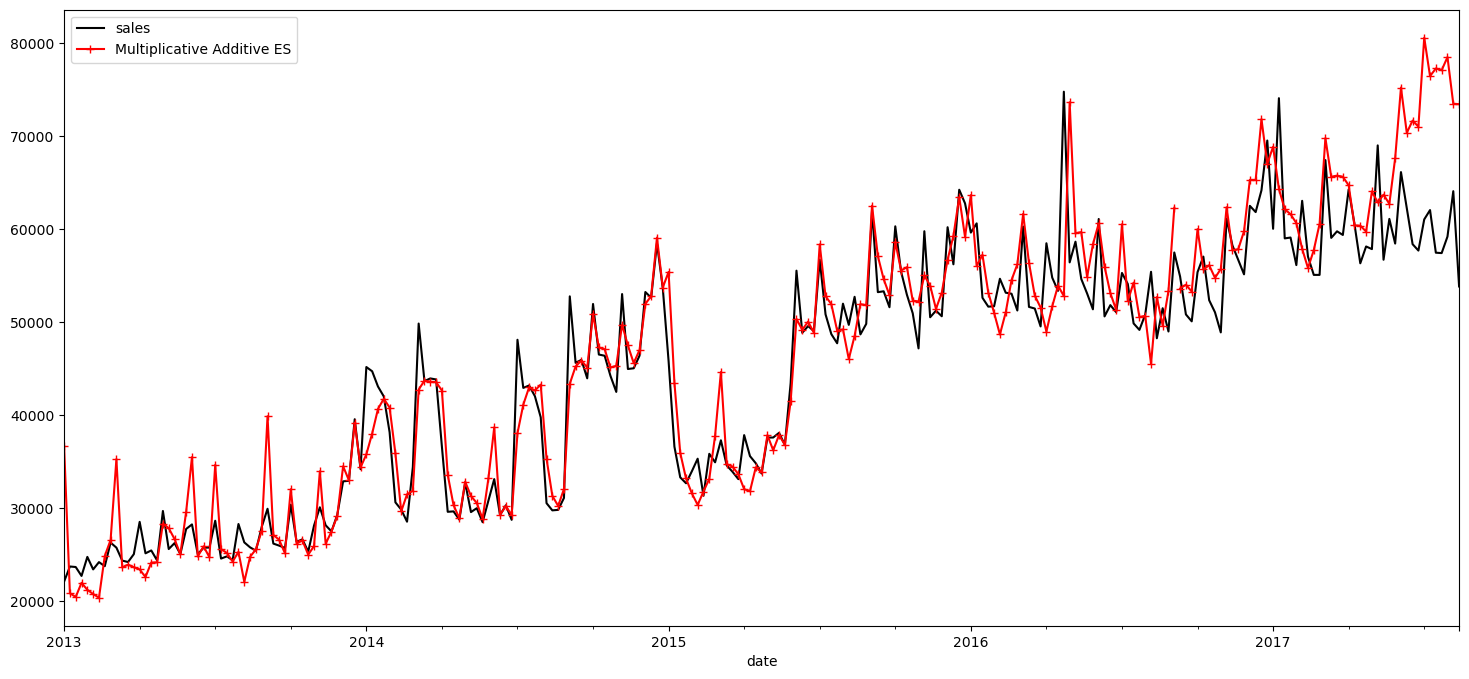

In [54]:
multiaddtive_model = ExponentialSmoothing(train, trend='mul', seasonal='add').fit()
multiaddtive_pred = multiaddtive_model.forecast(49).rename('Multiplicative Additive ES')

ax = df.plot( color='black', figsize=(18,8), legend=True)

multiaddtive_pred.plot(marker='+', ax=ax, color='red', legend=True)
multiaddtive_model.fittedvalues.plot(marker='+', ax=ax, color='red')

In [55]:
rmse_of_AAES = np.sqrt(mean_squared_error(y_true= test, y_pred= additive_pred))
mape_of_AAES = mean_absolute_percentage_error(y_true= test, y_pred= additive_pred)
print('Rmse of Both Additive Exponential Smoothing :',rmse_of_AAES)
print('Mape of Both Additive Exponential Smoothing :',mape_of_AAES)
print('')
rmse_of_AMES = np.sqrt(mean_squared_error(y_true= test, y_pred= addmulticative_pred ))
mape_of_AMES = mean_absolute_percentage_error(y_true= test, y_pred= addmulticative_pred)
print('Rmse of Additive Multiplicative Exponential Smoothing :',rmse_of_AMES)
print('Mape of Additive Multiplicative Exponential Smoothing :',mape_of_AMES)
print('')
rmse_of_MMES = np.sqrt(mean_squared_error(y_true= test, y_pred= multiplicative_pred))
mape_of_MMES = mean_absolute_percentage_error(y_true= test, y_pred= multiplicative_pred)
print('Rmse of Both Multiplicative Exponential Smoothing :',rmse_of_MMES)
print('Mape of Both Multiplicative Exponential Smoothing :',mape_of_MMES)
print('')
rmse_of_MAES = np.sqrt(mean_squared_error(y_true= test, y_pred= multiaddtive_pred))
mape_of_MAES = mean_absolute_percentage_error(y_true= test, y_pred= multiaddtive_pred)
print('Rmse of Multiplicative Additive Exponential Smoothing :',rmse_of_MAES)
print('Mape of Multiplicative Additive Exponential Smoothing :',mape_of_MAES)

Rmse of Both Additive Exponential Smoothing : 5387.637443681298
Mape of Both Additive Exponential Smoothing : 0.0679038227642755

Rmse of Additive Multiplicative Exponential Smoothing : 6926.500308475938
Mape of Additive Multiplicative Exponential Smoothing : 0.08517056753893548

Rmse of Both Multiplicative Exponential Smoothing : 9778.222497137818
Mape of Both Multiplicative Exponential Smoothing : 0.11387080796981847

Rmse of Multiplicative Additive Exponential Smoothing : 8542.506889734523
Mape of Multiplicative Additive Exponential Smoothing : 0.11023525524271827


In [56]:
Error = {'Models':pd.Series(['Simple_Exp_alpha_0.2','Double_Exp_Add','Double_Exp_Mul','Triple_Exp_add_add',
                             'Triple_Exp_add_mul','Triple_Exp_mul_mul','Triple_Exp_mul_add']),\
            'RMSE':pd.Series([rmse_of_SES_SL_2,rmse_of_AES,rmse_of_MES,rmse_of_AAES,rmse_of_AMES,rmse_of_MMES,rmse_of_MAES]),\
            'MAPE':pd.Series([mape_of_SES_SL_2,mape_of_AES,mape_of_MES,mape_of_AAES,mape_of_AMES,mape_of_MMES,mape_of_MAES])}
Check_best_model = pd.DataFrame(Error)
Check_best_model.sort_values(['MAPE'], inplace=True, ignore_index=True)
Check_best_model

,Models,RMSE,MAPE
0,Triple_Exp_add_add,5387.637444,0.067904
1,Triple_Exp_add_mul,6926.500308,0.085171
2,Double_Exp_Mul,6746.496968,0.094804
3,Double_Exp_Add,6855.468888,0.097276
4,Triple_Exp_mul_add,8542.506890,0.110235
5,Simple_Exp_alpha_0.2,8270.714274,0.113082
6,Triple_Exp_mul_mul,9778.222497,0.113871


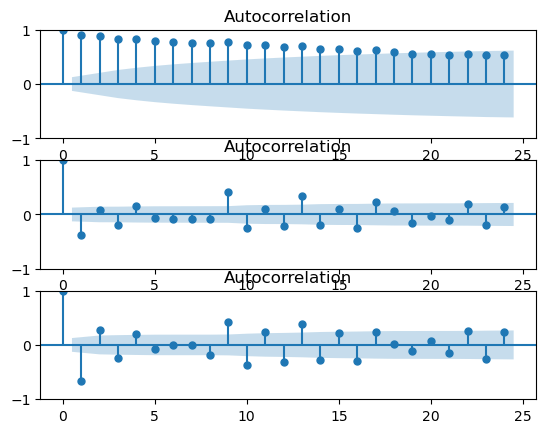

In [57]:
fig,(ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df, ax=ax1)
plot_acf(df.diff().dropna(), ax=ax2)
plot_acf(df.diff().diff().dropna(), ax=ax3)
plt.show()

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


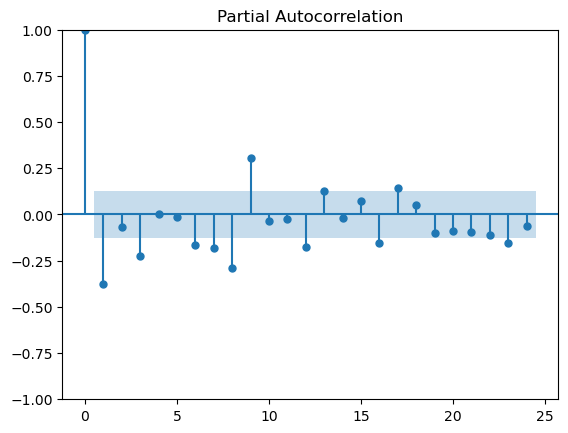

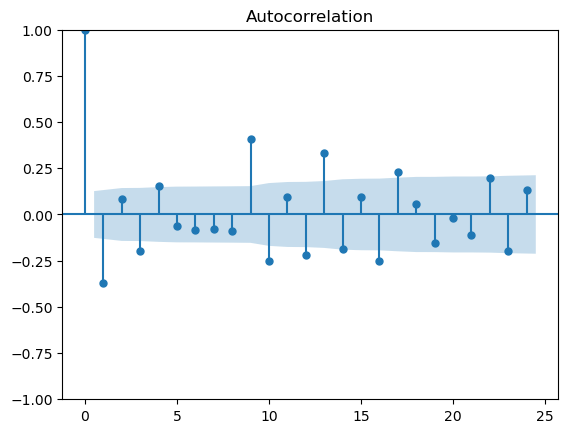

In [58]:
plot_pacf(df.diff().dropna())
plot_acf(df.diff().dropna())
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  192
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -1891.225
Date:                Mon, 11 Sep 2023   AIC                           3798.449
Time:                        15:19:16   BIC                           3824.467
Sample:                    01-06-2013   HQIC                          3808.988
                         - 09-04-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    335.1963    228.211      1.469      0.142    -112.089     782.481
ar.L1         -0.5316      0.154     -3.447      0.001      -0.834      -0.229
ar.L2          0.5087      0.227      2.243      0.025       0.064       0.953
ar.L3          0.0165      0.134      0.123      0.902      -0.246       0.279
ar.L4         -0.1814      0.110     -1.653      0.098      -0.396       0.034
ma.L1          0.1923      0.150      1.278      0.201      -0.103       0.487
ma.L2         -0.7291      0.178     -4.098      0.000      -1.078      -0.380
sigma2      2.462e+07      0.005   5.04e+09      0.000    2.46e+07    2.46e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               116.88
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+26. Standard errors may be unstable.
"""

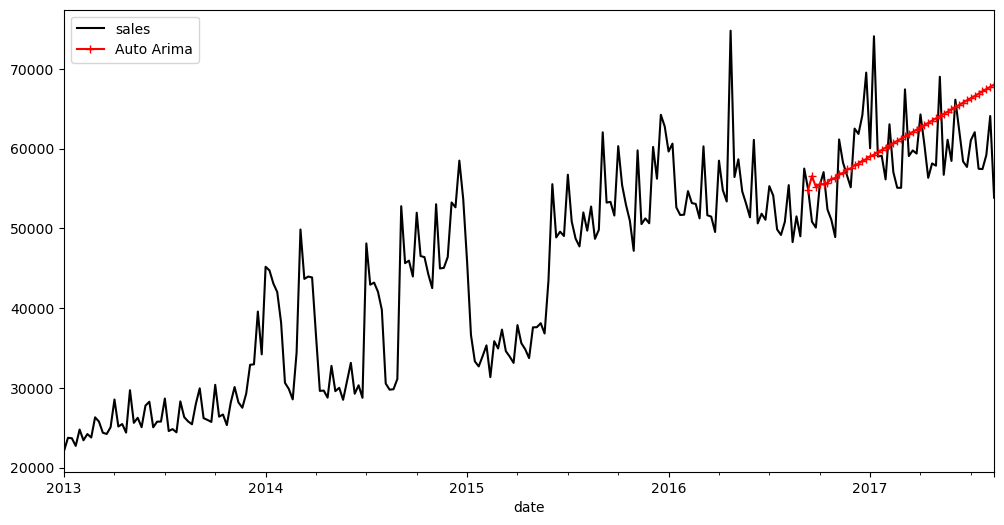

In [59]:
model = auto_arima(train, order = (3,1,3))
model_fit = model.fit(train)
model_predict = model_fit.predict(49).rename("Auto Arima")

ax = df.plot( color='black', figsize=(12,6), legend=True)
model_predict.plot(marker='+', ax=ax, color='red', legend=True)
model_fit.summary()

In [60]:
rmse_of_Auto_Arima = np.sqrt(mean_squared_error(y_true= test, y_pred= model_predict))
mape_of_Auto_Arima = mean_absolute_percentage_error(y_true= test, y_pred= model_predict)
print('Rmse of Auto Arima :',rmse_of_Auto_Arima)
print('Mape of Auto Arima :',mape_of_Auto_Arima)

Rmse of Auto Arima : 5820.744862001932
Mape of Auto Arima : 0.08148357167418473


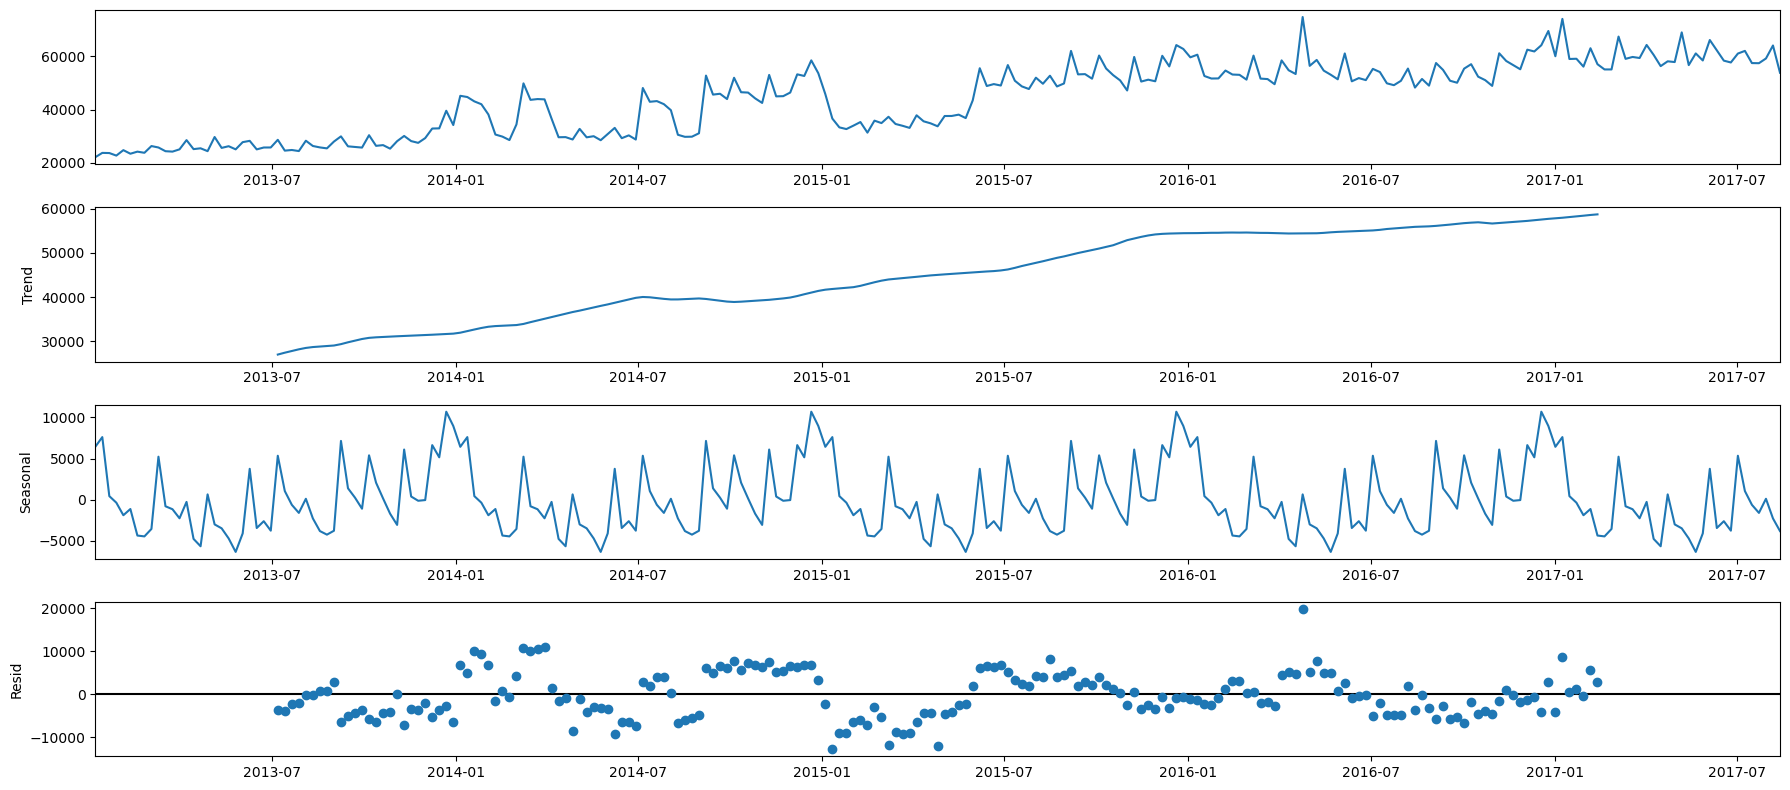

In [61]:
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

In [62]:
train

,sales
date,
2013-01-06,22115.704675
2013-01-13,23736.178362
2013-01-20,23680.074300
2013-01-27,22721.646701
2013-02-03,24768.906712
...,...
2016-08-07,55432.185400
2016-08-14,48283.157891
2016-08-21,51516.237768


In [63]:
sarimax_model = SARIMAX(train, order=(3,1,3), seasonal_order=(3,1,3,19))
sarimax_fit = sarimax_model.fit()
sarimax_fit.summary()

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  192
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 19)   Log Likelihood               -1734.660
Date:                            Mon, 11 Sep 2023   AIC                           3495.321
Time:                                    15:19:33   BIC                           3536.238
Sample:                                01-06-2013   HQIC                          3511.922
                                     - 09-04-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1456      0.280     -4.096      0.000      -1.694      -0.597
ar.L2          0.4960      0.503      0.986      0.324      -0.490       1.482
ar.L3          0.7518      0.251      2.993      0.003       0.260       1.244
ma.L1          0.9081      0.234      3.885      0.000       0.450       1.366
ma.L2         -0.8563      0.264     -3.249      0.001      -1.373      -0.340
ma.L3         -0.8410      0.165     -5.107      0.000      -1.164      -0.518
ar.S.L19       0.2581     17.599      0.015      0.988     -34.236      34.752
ar.S.L38      -0.6383     22.288     -0.029      0.977     -44.322      43.046
ar.S.L57      -0.3262      7.501     -0.043      0.965     -15.027      14.375
ma.S.L19      -1.1682     17.646     -0.066      0.947     -35.755      33.418
ma.S.L38       1.2255     17.992      0.068      0.946     -34.038      36.489
ma.S.L57      -0.4717      9.807     -0.048      0.962     -19.693      18.750
sigma2      5.759e+07   3.47e-05   1.66e+12      0.000    5.76e+07    5.76e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                35.28
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.78
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+28. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

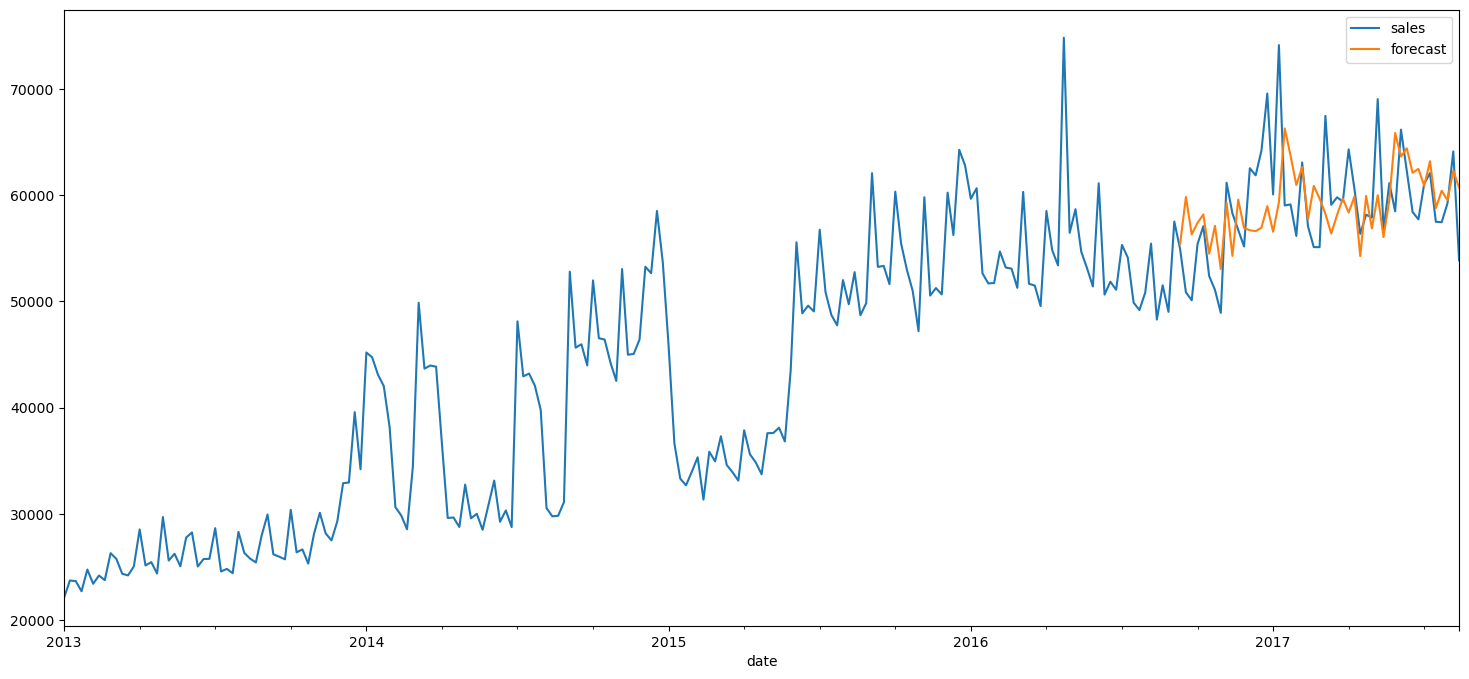

In [64]:
df['forecast']=sarimax_fit.predict(start=192,end=241,dynamic=True)
df[['sales','forecast']].plot(figsize=(18,8))

In [65]:
rmse_of_SARIMAX = np.sqrt(mean_squared_error(y_true= test, y_pred= df['forecast'].iloc[192:]))
mape_of_SARIMAX = mean_absolute_percentage_error(y_true= test, y_pred= df['forecast'].iloc[192:])
print('Rmse of Auto Arima :',rmse_of_SARIMAX)
print('Mape of Auto Arima :',mape_of_SARIMAX)

Rmse of Auto Arima : 4966.738347694984
Mape of Auto Arima : 0.06433324831026431


In [66]:
df

,sales,forecast
date,,
2013-01-06,22115.704675,NaN
2013-01-13,23736.178362,NaN
2013-01-20,23680.074300,NaN
2013-01-27,22721.646701,NaN
2013-02-03,24768.906712,NaN
...,...,...
2017-07-16,57485.154291,58771.838803
2017-07-23,57443.351642,60404.727401
2017-07-30,59218.118568,59524.207664


In [67]:
df = df.drop(['forecast'],axis = 1)
df

,sales
date,
2013-01-06,22115.704675
2013-01-13,23736.178362
2013-01-20,23680.074300
2013-01-27,22721.646701
2013-02-03,24768.906712
...,...
2017-07-16,57485.154291
2017-07-23,57443.351642
2017-07-30,59218.118568


In [68]:
df['sales_diff'] = df['sales'].shift(1)
df['sales_diff1'] = df['sales'].shift(2)
df = df.dropna()
df

,sales,sales_diff,sales_diff1
date,,,
2013-01-20,23680.074300,23736.178362,22115.704675
2013-01-27,22721.646701,23680.074300,23736.178362
2013-02-03,24768.906712,22721.646701,23680.074300
2013-02-10,23424.696602,24768.906712,22721.646701
2013-02-17,24206.086147,23424.696602,24768.906712
...,...,...,...
2017-07-16,57485.154291,62070.491355,61064.773805
2017-07-23,57443.351642,57485.154291,62070.491355
2017-07-30,59218.118568,57443.351642,57485.154291


In [69]:
X = df.iloc[:,1:].values

In [70]:
X

array([[23736.17836207, 22115.70467477],
       [23680.07430049, 23736.17836207],
       [22721.64670099, 23680.07430049],
       [24768.90671228, 22721.64670099],
       [23424.69660249, 24768.90671228],
       [24206.08614691, 23424.69660249],
       [23772.00990538, 24206.08614691],
       [26306.30124157, 23772.00990538],
       [25763.8371325 , 26306.30124157],
       [24371.64704186, 25763.8371325 ],
       [24217.28277832, 24371.64704186],
       [25066.44391871, 24217.28277832],
       [28538.86110653, 25066.44391871],
       [25153.10018752, 28538.86110653],
       [25462.53942067, 25153.10018752],
       [24390.32325628, 25462.53942067],
       [29705.65755842, 24390.32325628],
       [25613.96343228, 29705.65755842],
       [26248.65236956, 25613.96343228],
       [25069.62940119, 26248.65236956],
       [27774.96381739, 25069.62940119],
       [28260.95622215, 27774.96381739],
       [25054.74497873, 28260.95622215],
       [25759.77657202, 25054.74497873],
       [25771.95

In [71]:
y = df.iloc[:,0].values

In [72]:
y

array([23680.07430049, 22721.64670099, 24768.90671228, 23424.69660249,
       24206.08614691, 23772.00990538, 26306.30124157, 25763.8371325 ,
       24371.64704186, 24217.28277832, 25066.44391871, 28538.86110653,
       25153.10018752, 25462.53942067, 24390.32325628, 29705.65755842,
       25613.96343228, 26248.65236956, 25069.62940119, 27774.96381739,
       28260.95622215, 25054.74497873, 25759.77657202, 25771.95975008,
       28658.10936229, 24586.95915321, 24824.90878043, 24423.72624091,
       28306.40814059, 26329.79755926, 25794.39520765, 25435.06163698,
       27996.59140897, 29945.40145991, 26199.80428678, 25979.94868546,
       25729.43116764, 30381.9641329 , 26387.6514606 , 26658.70620041,
       25328.91582053, 28140.14393111, 30103.4746018 , 28168.70411048,
       27509.89410763, 29295.19795962, 32891.79235717, 32955.289958  ,
       39575.45872051, 34202.46516518, 45189.33211491, 44732.84333363,
       43094.99942233, 42026.17190688, 38183.8115861 , 30634.57892371,
      

In [73]:
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

In [74]:
X_train.shape

(191, 2)

In [75]:
X_test.shape

(48, 2)

In [76]:
regressor = LinearRegression()
regressor_fit = regressor.fit(X_train, y_train)
regressor_pred = regressor_fit.predict(X_test)

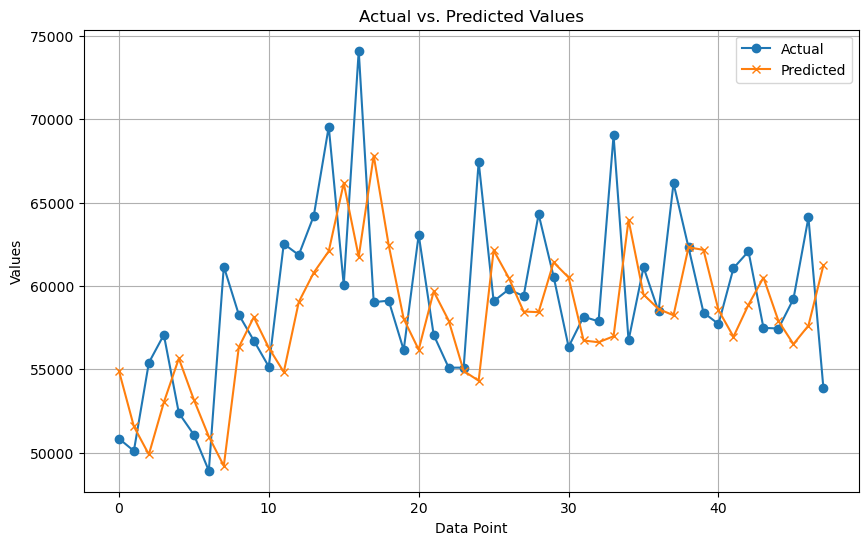

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(regressor_pred, label='Predicted', marker='x')
plt.xlabel("Data Point")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

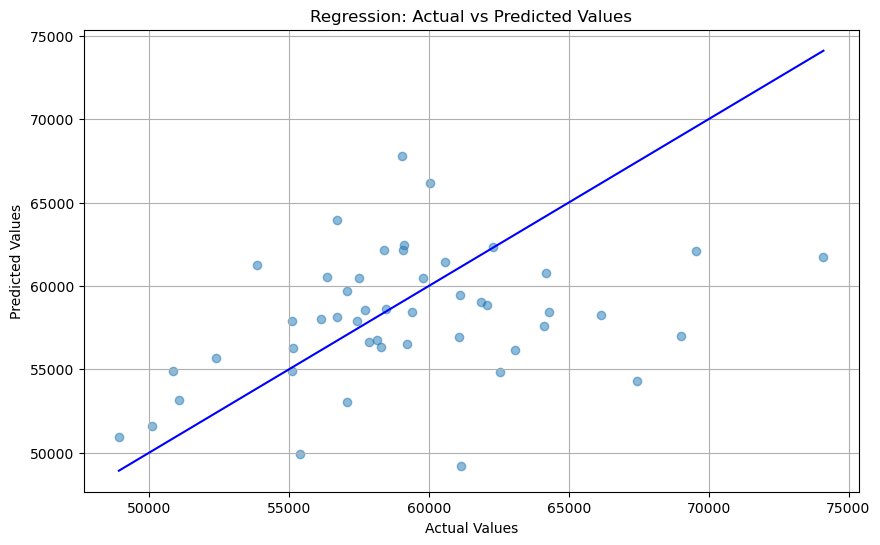

In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, regressor_pred, alpha=0.5)

p1 = max(max(regressor_pred), max(y_test))
p2 = min(min(regressor_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Regression: Actual vs Predicted Values")
plt.grid(True)
plt.show()


In [79]:
Coefficient_regression = regressor_fit.coef_
rmse_of_regression = np.sqrt(mean_squared_error(y_true= y_test, y_pred= regressor_pred))
mape_of_regression = mean_absolute_percentage_error(y_true= y_test, y_pred= regressor_pred)
print('Coefficient of regression :', Coefficient_regression)
print('Rmse of regression :',rmse_of_regression)
print('Mape of regression :',mape_of_regression)

Coefficient of regression : [0.63284974 0.29688926]
Rmse of regression : 5342.9011102313025
Mape of regression : 0.06744331516069152


In [80]:
knn_model = KNeighborsRegressor(n_neighbors=5,p=2,metric='minkowski')
knn_fit = knn_model.fit(X_train, y_train)
knn_pred = knn_fit.predict(X_test)

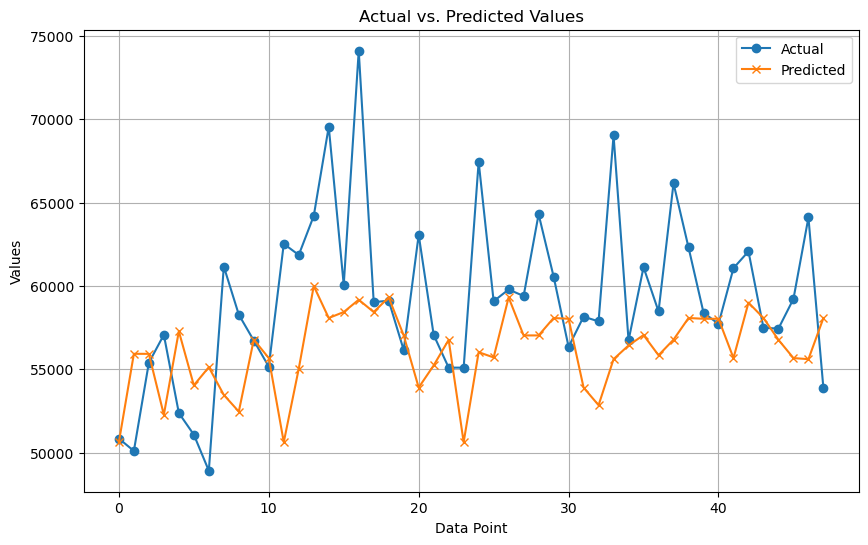

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(knn_pred, label='Predicted', marker='x')
plt.xlabel("Data Point")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

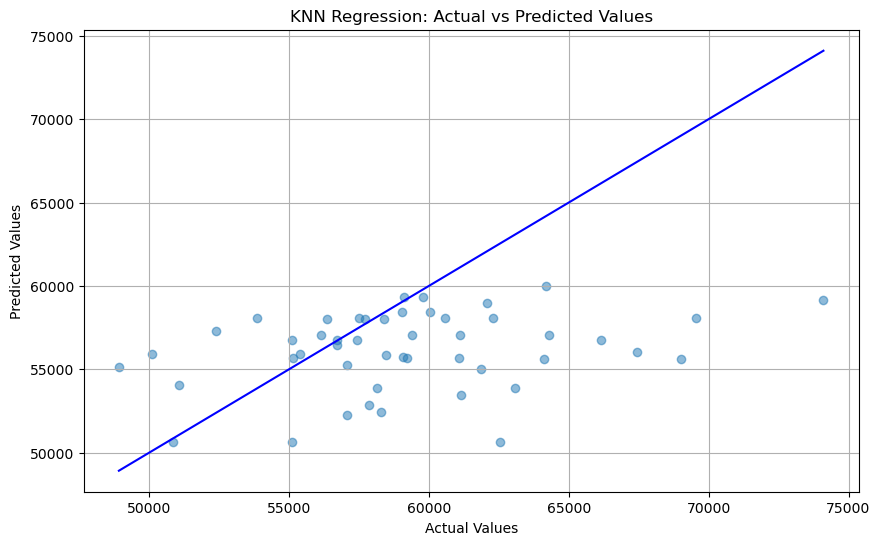

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, knn_pred, alpha=0.5)

p1 = max(max(knn_pred), max(y_test))
p2 = min(min(knn_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("KNN Regression: Actual vs Predicted Values")
plt.grid(True)
plt.show()

In [83]:
rmse_of_knn = np.sqrt(mean_squared_error(y_true= y_test, y_pred= knn_pred))
mape_of_knn = mean_absolute_percentage_error(y_true= y_test, y_pred= knn_pred)
print('Rmse of knn :',rmse_of_knn)
print('Mape of knn :',mape_of_knn)

Rmse of knn : 5774.356647151726
Mape of knn : 0.07056417868945573


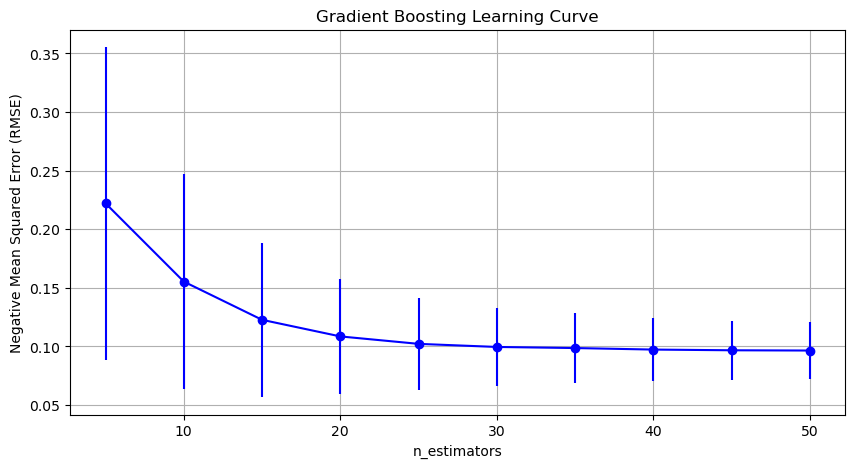

In [84]:
n_estimators_range = [5,10,15,20,25,30,35,40,45,50]

cv_scores_mean = []
cv_scores_std = []

#Cross_Validation
for n_estimators in n_estimators_range:
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=0.1, max_depth=3, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    cv_scores_mean.append(-cv_scores.mean())
    cv_scores_std.append(cv_scores.std())

plt.figure(figsize=(10, 5))
plt.errorbar(n_estimators_range, cv_scores_mean, yerr=cv_scores_std, marker='o', linestyle='-', color='b')
plt.title('Gradient Boosting Learning Curve')
plt.xlabel('n_estimators')
plt.ylabel('Negative Mean Squared Error (RMSE)')
plt.grid(True)

In [85]:
gbs = GradientBoostingRegressor(n_estimators=20,learning_rate=0.5,max_depth=2,random_state=42)
gbs_fit = gbs.fit(X_train, y_train)
gbs_pred = gbs_fit.predict(X_test)

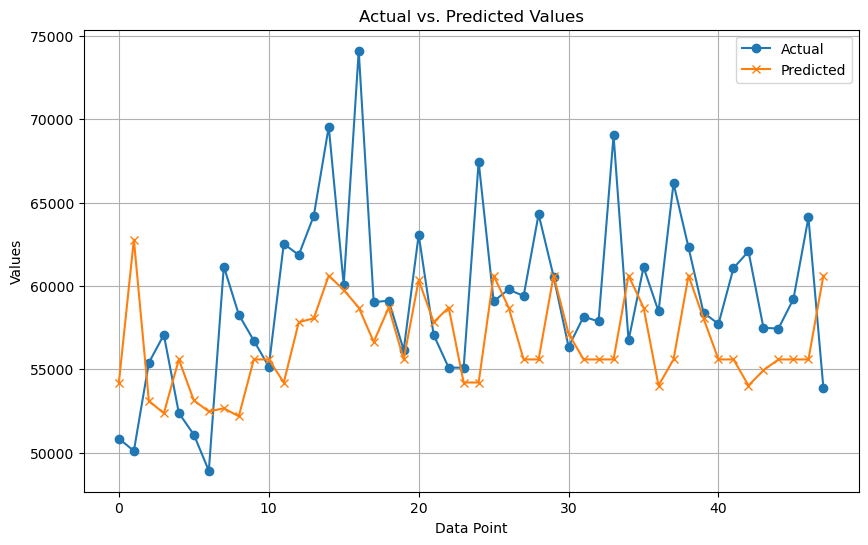

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(gbs_pred, label='Predicted', marker='x')
plt.xlabel("Data Point")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

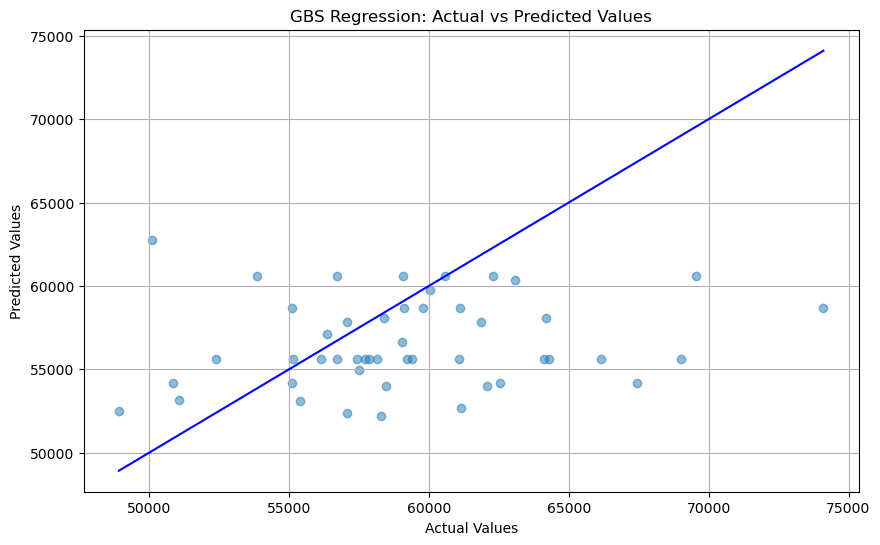

In [87]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbs_pred, alpha=0.5)

p1 = max(max(gbs_pred), max(y_test))
p2 = min(min(gbs_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("GBS Regression: Actual vs Predicted Values")
plt.grid(True)
plt.show()

In [88]:
rmse_of_gbs = np.sqrt(mean_squared_error(y_true= y_test, y_pred= gbs_pred))
mape_of_gbs = mean_absolute_percentage_error(y_true= y_test, y_pred= gbs_pred)
print('Rmse of Gradient Boosting Regressor :',rmse_of_gbs)
print('Mape of Gradient Boosting Regressor :',mape_of_gbs)

Rmse of Gradient Boosting Regressor : 5886.373536484441
Mape of Gradient Boosting Regressor : 0.07252299913880171


In [89]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [90]:
trainX

array([[[23736.17836207, 22115.70467477]],

       [[23680.07430049, 23736.17836207]],

       [[22721.64670099, 23680.07430049]],

       [[24768.90671228, 22721.64670099]],

       [[23424.69660249, 24768.90671228]],

       [[24206.08614691, 23424.69660249]],

       [[23772.00990538, 24206.08614691]],

       [[26306.30124157, 23772.00990538]],

       [[25763.8371325 , 26306.30124157]],

       [[24371.64704186, 25763.8371325 ]],

       [[24217.28277832, 24371.64704186]],

       [[25066.44391871, 24217.28277832]],

       [[28538.86110653, 25066.44391871]],

       [[25153.10018752, 28538.86110653]],

       [[25462.53942067, 25153.10018752]],

       [[24390.32325628, 25462.53942067]],

       [[29705.65755842, 24390.32325628]],

       [[25613.96343228, 29705.65755842]],

       [[26248.65236956, 25613.96343228]],

       [[25069.62940119, 26248.65236956]],

       [[27774.96381739, 25069.62940119]],

       [[28260.95622215, 27774.96381739]],

       [[25054.74497873, 28260.9

In [91]:
lstm = Sequential()
lstm.add(LSTM(24, activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mape')
lstm_fit = lstm.fit(trainX, y_train, epochs=50,  batch_size=1, verbose=2)

Epoch 1/50
191/191 - 1s - loss: 37.0203 - 1s/epoch - 5ms/step
Epoch 2/50
191/191 - 0s - loss: 8.1235 - 187ms/epoch - 977us/step
Epoch 3/50
191/191 - 0s - loss: 7.9098 - 184ms/epoch - 966us/step
Epoch 4/50
191/191 - 0s - loss: 7.8641 - 184ms/epoch - 963us/step
Epoch 5/50
191/191 - 0s - loss: 7.9309 - 174ms/epoch - 912us/step
Epoch 6/50
191/191 - 0s - loss: 7.9433 - 188ms/epoch - 987us/step
Epoch 7/50
191/191 - 0s - loss: 7.7756 - 181ms/epoch - 950us/step
Epoch 8/50
191/191 - 0s - loss: 7.8073 - 176ms/epoch - 923us/step
Epoch 9/50
191/191 - 0s - loss: 7.7464 - 175ms/epoch - 915us/step
Epoch 10/50
191/191 - 0s - loss: 7.8251 - 186ms/epoch - 975us/step
Epoch 11/50
191/191 - 0s - loss: 7.7604 - 182ms/epoch - 952us/step
Epoch 12/50
191/191 - 0s - loss: 7.8276 - 173ms/epoch - 906us/step
Epoch 13/50
191/191 - 0s - loss: 7.7521 - 179ms/epoch - 935us/step
Epoch 14/50
191/191 - 0s - loss: 7.7328 - 187ms/epoch - 981us/step
Epoch 15/50
191/191 - 0s - loss: 7.6356 - 184ms/epoch - 962us/step
Epoch 16

In [92]:
lstm_pred = lstm.predict(testX)

2/2 [==============================] - 0s 3ms/step


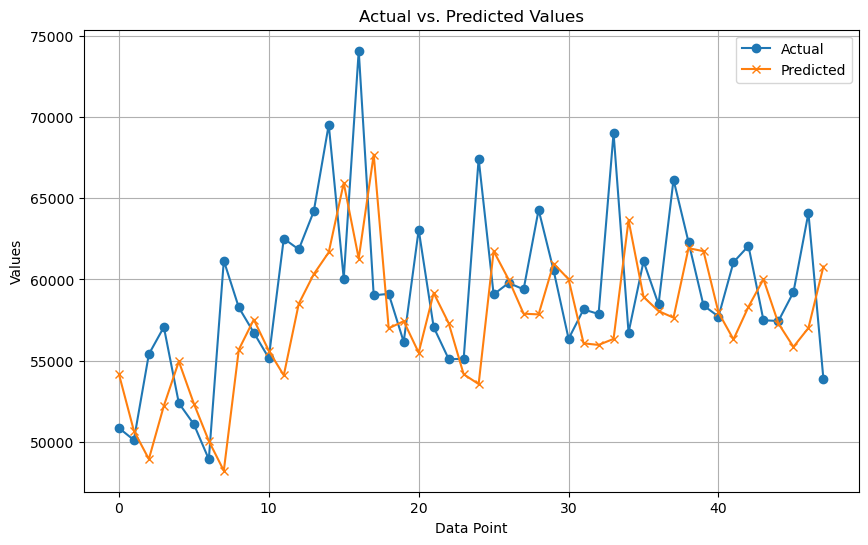

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(lstm_pred, label='Predicted', marker='x')
plt.xlabel("Data Point")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\aksha\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


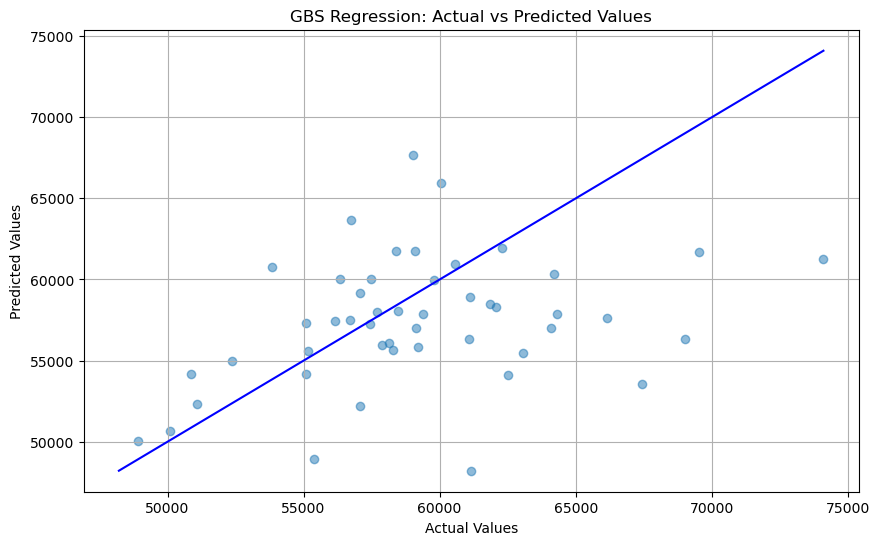

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lstm_pred, alpha=0.5)

p1 = max(max(lstm_pred), max(y_test))
p2 = min(min(lstm_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("GBS Regression: Actual vs Predicted Values")
plt.grid(True)
plt.show()

In [95]:
rmse_of_lstm = np.sqrt(mean_squared_error(y_true= y_test, y_pred= lstm_pred))
mape_of_lstm = mean_absolute_percentage_error(y_true= y_test, y_pred= lstm_pred)
print('Rmse of LSTM :',rmse_of_lstm)
print('Mape of LSTM :',mape_of_lstm)

Rmse of LSTM : 5562.645768025638
Mape of LSTM : 0.06784448088113924


In [96]:
Error = {'Models':pd.Series(['Auto Arima','SARIMAX','Linear Regression','Gradient Boosting Regressor','LSTM']),\
            'RMSE':pd.Series([rmse_of_Auto_Arima,rmse_of_SARIMAX,rmse_of_regression,rmse_of_gbs,rmse_of_lstm]),\
            'MAPE':pd.Series([mape_of_Auto_Arima,mape_of_SARIMAX,mape_of_regression,mape_of_gbs,mape_of_lstm])}
Check_best_model = pd.DataFrame(Error)
Check_best_model.sort_values(['MAPE'], inplace=True, ignore_index=True)
Check_best_model

,Models,RMSE,MAPE
0,SARIMAX,4966.738348,0.064333
1,Linear Regression,5342.901110,0.067443
2,LSTM,5562.645768,0.067844
3,Gradient Boosting Regressor,5886.373536,0.072523
4,Auto Arima,5820.744862,0.081484
